### Trained on a single subject

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



## Data are separated by participant
Each file contains the following information
sequential number, x acceleration, y acceleration, z acceleration, label
Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing


In [2]:
df_all = pd.read_csv("1.csv", names=["Sequence", "x", "y", "z","label"])
df_all=df_all.drop('Sequence',axis=1)
df_all.head()

,x,y,z,label
0,1502,2215,2153,1
1,1667,2072,2047,1
2,1611,1957,1906,1
3,1601,1939,1831,1
4,1643,1965,1879,1


#### Class Distribution 

<AxesSubplot:xlabel='label', ylabel='count'>

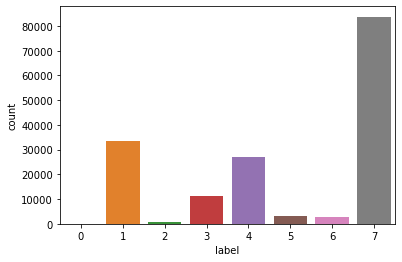

In [3]:
sns.countplot(x = 'label', data=df_all)

<AxesSubplot:xlabel='label', ylabel='count'>

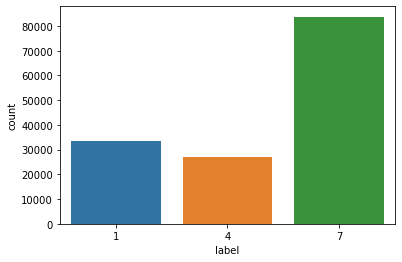

In [4]:
options=[1,4,7]
df= df_all.loc[df_all['label'].isin(options)]
sns.countplot(x = 'label', data=df)

In [5]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
print(X.shape)

(144285, 3)


<bound method NDFrame.head of            x     y     z  label
0       1502  2215  2153      1
1       1667  2072  2047      1
2       1611  1957  1906      1
3       1601  1939  1831      1
4       1643  1965  1879      1
...      ...   ...   ...    ...
251239  1927  2401  2039      4
251240  1902  2390  2023      4
251241  1848  2482  2068      4
251242  1864  2317  2017      4
251243  1899  2489  2020      4

[251244 rows x 4 columns]>


<AxesSubplot:xlabel='label', ylabel='count'>

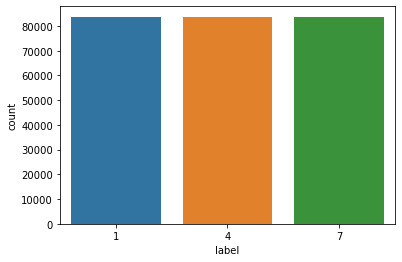

In [6]:
#Over Sample
ros= RandomOverSampler(random_state=0)
ros.fit(X,y)
X_resampled, y_resampled = ros.fit_sample(X,y)
df_resample = pd.concat([X_resampled,y_resampled], axis = 1)
print(df_resample.head)
sns.countplot(x = 'label', data=df_resample)

#### Encode Output
Pytorch supports labels from 0. [0,n]
- Dictionary class2idx , .replace method to change it, idx2class for reverse mapping

In [7]:
class2idx = {
    1:0,
    3:1,
    4:2,
    7:3
}

idx2class = {v: k for k, v in class2idx.items()}  # will be used later for reverse mapping

df_resample['label'].replace(class2idx, inplace=True)

In [8]:
df_resample.head(-5)
#df_resample.to_csv(r'C:\Users\antonebert\Desktop\WS2021 Programing\MADI\file.csv', index= None, header=True)

,x,y,z,label
0,1502,2215,2153,0
1,1667,2072,2047,0
2,1611,1957,1906,0
3,1601,1939,1831,0
4,1643,1965,1879,0
...,...,...,...,...
251234,1848,2385,2026,2
251235,1919,2285,2035,2
251236,1907,2317,2001,2
251237,1869,2238,2001,2


In [9]:
#Create input output data
X = df_resample.iloc[:, 0:-1]
y = df_resample.iloc[:, -1]

#### Stratification
Let’s assume you are doing a multiclass classification and have an imbalanced dataset that has 5 different classes. You do a simple train-test split that does a random split totally disregarding the distribution or proportions of the classes. What happens in this scenario is that you end up with a train and a test set with totally different data distributions. A model trained on a vastly different data distribution than the test set will perform inferiorly at validation. 
For more info: https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

In [10]:
# Split into train+val (80%) and test(20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69) 

# Split train into train-val(train 72%, val 8%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


#### fit: transform: fit_transform:

"fit" computes the mean and std to be used for later scaling. (just a computation), nothing is given to you. 
"transform" uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). 
"fit_transform" does both at the same time.

#### Note:
We use .fit_transform() on X_train while we use .transform() on X_val and X_test.
We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage.


In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) #mean and std used later to autoscale
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

## Neural Network

In [12]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [13]:
EPOCHS = 2 # Notable result with 50 Epochs
BATCH_SIZE = 8
LEARNING_RATE = 0.05
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 4


#### Dataloader

In [14]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

#### Define Neural Net Architechture

In [15]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Train Model

In [18]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [19]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [20]:
print("Training....")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Training....


Epoch 001: | Train Loss: 0.48295 | Val Loss: 0.36839 | Train Acc: 95.710| Val Acc: 87.010
Epoch 002: | Train Loss: 0.45432 | Val Loss: 0.28033 | Train Acc: 96.727| Val Acc: 91.826



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

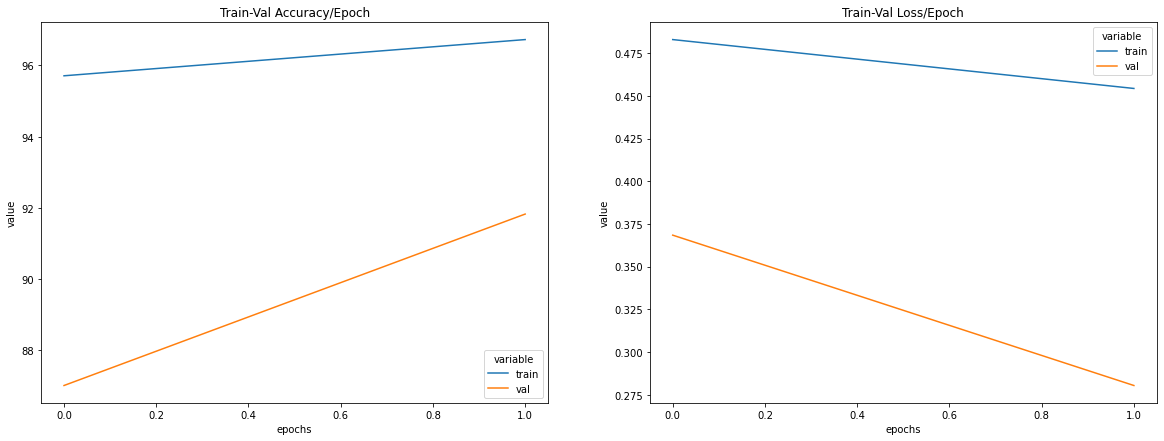

In [21]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [26]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
confusion_matrix = df.values
print(confusion_matrix_df)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
confusion_matrix=(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])
print(np.round(confusion_matrix,2))

vmin = np.min(confusion_matrix)
vmax = np.max(confusion_matrix)
off_diag_mask = np.eye(*confusion_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

In [24]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
print(confusion_matrix_df)
sns.heatmap(confusion_matrix_df, annot=True)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98      6735
           2       0.00      0.00      0.00       186
           3       0.51      0.60      0.55      2236
           4       0.81      0.97      0.88      5372
           5       0.62      0.64      0.63       638
           6       0.32      0.50      0.39       583
           7       1.00      0.91      0.96     16750

    accuracy                           0.89     32500
   macro avg       0.61      0.66      0.63     32500
weighted avg       0.91      0.89      0.90     32500

In [ ]:
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
confusion_matrix=(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis])
print(np.round(confusion_matrix,2))


vmin = np.min(confusion_matrix)
vmax = np.max(confusion_matrix)
off_diag_mask = np.eye(*confusion_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(1,2, width_ratios=[20,2], hspace=0.05)
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], hspace=0)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

sns.heatmap(confusion_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax2)
sns.heatmap(confusion_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, ax=ax, cbar_ax=cax1, cbar_kws=dict(ticks=[]))

Epoch 001: | Train Loss: 0.49286 | Val Loss: 0.32999 | Train Acc: 95.011| Val Acc: 91.363
Epoch 002: | Train Loss: 0.47898 | Val Loss: 0.30429 | Train Acc: 96.139| Val Acc: 91.109
Epoch 003: | Train Loss: 0.46675 | Val Loss: 0.27551 | Train Acc: 96.436| Val Acc: 92.308
Epoch 004: | Train Loss: 0.46143 | Val Loss: 0.31259 | Train Acc: 96.555| Val Acc: 92.100
Epoch 005: | Train Loss: 0.45798 | Val Loss: 0.27125 | Train Acc: 96.692| Val Acc: 92.697
Epoch 006: | Train Loss: 0.45565 | Val Loss: 0.27787 | Train Acc: 96.834| Val Acc: 92.682
Epoch 007: | Train Loss: 0.45054 | Val Loss: 0.30225 | Train Acc: 96.798| Val Acc: 92.199
Epoch 008: | Train Loss: 0.44733 | Val Loss: 0.29979 | Train Acc: 96.935| Val Acc: 92.189
Epoch 009: | Train Loss: 0.44571 | Val Loss: 0.26510 | Train Acc: 97.055| Val Acc: 92.980
Epoch 010: | Train Loss: 0.44381 | Val Loss: 0.27590 | Train Acc: 97.033| Val Acc: 92.159
Epoch 011: | Train Loss: 0.44235 | Val Loss: 0.25677 | Train Acc: 97.165| Val Acc: 92.960
Epoch 012: | Train Loss: 0.44110 | Val Loss: 0.28537 | Train Acc: 97.094| Val Acc: 92.861
Epoch 013: | Train Loss: 0.44351 | Val Loss: 0.26033 | Train Acc: 97.254| Val Acc: 92.816
Epoch 014: | Train Loss: 0.44890 | Val Loss: 0.30858 | Train Acc: 96.860| Val Acc: 92.826
Epoch 015: | Train Loss: 0.47394 | Val Loss: 0.29157 | Train Acc: 96.033| Val Acc: 93.085
Epoch 016: | Train Loss: 0.47211 | Val Loss: 0.27265 | Train Acc: 96.104| Val Acc: 93.124
Epoch 017: | Train Loss: 0.47135 | Val Loss: 0.29415 | Train Acc: 96.122| Val Acc: 92.836
Epoch 018: | Train Loss: 0.46762 | Val Loss: 0.27461 | Train Acc: 96.254| Val Acc: 92.900
Epoch 019: | Train Loss: 0.46677 | Val Loss: 0.29363 | Train Acc: 96.356| Val Acc: 92.502
Epoch 020: | Train Loss: 0.46617 | Val Loss: 0.30098 | Train Acc: 96.183| Val Acc: 92.453
Epoch 021: | Train Loss: 0.46892 | Val Loss: 0.28360 | Train Acc: 96.152| Val Acc: 92.841
Epoch 022: | Train Loss: 0.46599 | Val Loss: 0.30246 | Train Acc: 96.347| Val Acc: 91.433
Epoch 023: | Train Loss: 0.46148 | Val Loss: 0.31003 | Train Acc: 96.351| Val Acc: 92.189
Epoch 024: | Train Loss: 0.46512 | Val Loss: 0.28801 | Train Acc: 96.294| Val Acc: 92.965
Epoch 025: | Train Loss: 0.46125 | Val Loss: 0.30176 | Train Acc: 96.595| Val Acc: 91.682
Epoch 026: | Train Loss: 0.46411 | Val Loss: 0.29081 | Train Acc: 96.378| Val Acc: 93.129
Epoch 027: | Train Loss: 0.46327 | Val Loss: 0.28346 | Train Acc: 96.466| Val Acc: 92.333
Epoch 028: | Train Loss: 0.46216 | Val Loss: 0.27142 | Train Acc: 96.369| Val Acc: 92.403
Epoch 029: | Train Loss: 0.46289 | Val Loss: 0.31022 | Train Acc: 96.400| Val Acc: 92.413
Epoch 030: | Train Loss: 0.46105 | Val Loss: 0.29585 | Train Acc: 96.281| Val Acc: 90.716
Epoch 031: | Train Loss: 0.45943 | Val Loss: 0.26146 | Train Acc: 96.586| Val Acc: 93.095
Epoch 032: | Train Loss: 0.45979 | Val Loss: 0.28158 | Train Acc: 96.374| Val Acc: 92.697
Epoch 033: | Train Loss: 0.46124 | Val Loss: 0.30670 | Train Acc: 96.462| Val Acc: 92.284
Epoch 034: | Train Loss: 0.45890 | Val Loss: 0.33790 | Train Acc: 96.595| Val Acc: 92.015
Epoch 035: | Train Loss: 0.46044 | Val Loss: 0.28986 | Train Acc: 96.312| Val Acc: 92.139
Epoch 036: | Train Loss: 0.45865 | Val Loss: 0.28825 | Train Acc: 96.608| Val Acc: 92.731
Epoch 037: | Train Loss: 0.45981 | Val Loss: 0.33181 | Train Acc: 96.577| Val Acc: 91.114
Epoch 038: | Train Loss: 0.52391 | Val Loss: 0.31426 | Train Acc: 92.000| Val Acc: 92.896
Epoch 039: | Train Loss: 0.53458 | Val Loss: 0.35533 | Train Acc: 91.478| Val Acc: 92.144
Epoch 040: | Train Loss: 0.53484 | Val Loss: 0.32656 | Train Acc: 91.182| Val Acc: 92.736
Epoch 041: | Train Loss: 0.53206 | Val Loss: 0.34569 | Train Acc: 90.846| Val Acc: 92.244
Epoch 042: | Train Loss: 0.64183 | Val Loss: 0.47846 | Train Acc: 88.024| Val Acc: 92.816
Epoch 043: | Train Loss: 0.65622 | Val Loss: 0.44762 | Train Acc: 87.759| Val Acc: 92.657
Epoch 044: | Train Loss: 0.65364 | Val Loss: 0.53649 | Train Acc: 87.431| Val Acc: 90.861
Epoch 045: | Train Loss: 0.65245 | Val Loss: 0.42388 | Train Acc: 88.046| Val Acc: 92.995
Epoch 046: | Train Loss: 0.65295 | Val Loss: 0.58270 | Train Acc: 87.913| Val Acc: 92.493
Epoch 047: | Train Loss: 0.65275 | Val Loss: 0.54105 | Train Acc: 87.577| Val Acc: 90.244
Epoch 048: | Train Loss: 0.65066 | Val Loss: 0.44906 | Train Acc: 87.608| Val Acc: 92.652
Epoch 049: | Train Loss: 0.64728 | Val Loss: 0.45834 | Train Acc: 88.139| Val Acc: 92.980
Epoch 050: | Train Loss: 0.64898 | Val Loss: 0.63187 | Train Acc: 88.139| Val Acc: 83.766
